

### Moussa EL OUAFI: moussa.el_ouafi@ens-paris-saclay.fr

# Project : Detection Theory.
## **Image Forgery Detection Based on Statistical Features of Blcok DCT Coefficients**.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import numpy as np
from skimage.util import view_as_windows
from scipy.fftpack import dct

In [ ]:
def patches(image):
    """
    Extract patches from an image.
    Input : 
    - image_mat : The image as a matrix.
    Output :
    - The patches list.
    """

    stride=8                      # The stride has the same value as the window's width, which allows the patches to be non-overlapping. 
    w, h = (8, 8)
    image_mat=np.array(image)     # The image is being converted to a numpy array to undergo processing.
  
    windows = view_as_windows(image_mat, (w,h), step=stride)
    patches = []
    for m in range(w):
        for n in range(h) :
            patches = patches + [windows[m][n]]
    return patches

In [ ]:
def std_ones(blocks):

  """
  Input : 
  - blocks matrix : Array of N non-overlapping blocks of size 8x8 of the image.
  Output : 
  - ac_DCT_std : row-wise standard deviation of M_A, the matrix resulting of the columns-wise concatenation of AC coefficients for each block.
  - nbr_ones : number of ones per row in M_A. 
  """
  
  nbr_ones = []
  M_A = []

  for block in blocks:
      DCT = dct(block, type=2, n=None, axis=-1, norm=None, overwrite_x=False)            # We apply DCT to each block.
      DCT = DCT.flatten()               # We convert the 2d dct array to a 1d row array by flattening it.
      ac_dct_row = DCT[1:]              # We only keep the 63 AC components and remove (the first) DC component. 
      M_A.append(ac_dct_row)

  M_A = np.asarray(M_A) 
  M_A = M_A.T 
  ac_DCT_std = np.std(M_A, axis=1)      # We compute the row-wise standard-deviation.

  r, c = M_A.shape
  for i in range(r):
      count_one = 0
      for j in range(c):
          if(M_A[i][j]>0):              # row-wise counting of number of ones.
              count_one+=1
      nbr_ones.append(count_one)
  nbr_ones = np.asarray(nbr_ones)

  return (ac_DCT_std, nbr_ones)

In [ ]:
def features_vector(sub_image):

    """ Computes the feature vector of the sub-image.
    """

    sub_image_blocks = patches(sub_image)                 # We divide the sub-image into N non-overlapping blocks of siwe 8x8.
    sub_image_cropped = sub_image[4:,4:]                  # We crop the sub-image by removing 4 columns and 4 rows from the top left corner. 
    sub_image_cropped_blocks = patches(sub_image_cropped) # We divide the cropped sub-image in 8x8 sized blocks.

    # We compute the std columns vector for both the sub-image and the cropped sub-image :
    std_image, one_image = std_ones(sub_image_blocks)
    std_cropped_image, one_cropped_image = std_ones(sub_image_cropped_blocks)

    # We compute the feature vector by concatenating S.T, O.T, Sc.T and Oc.T (paper notation), then we flatten it column-wise : 
    F_sub_image=np.column_stack((std_image, one_image, std_cropped_image, one_cropped_image))
    F_sub_image_flat=F_sub_image.T.flatten() 
    
    return F_sub_image_flat

In [ ]:
import cv2
import os

In [ ]:
def features(folder_path, label):

    """ Computes the features vector for all images in a given path and stores them in a list """

    data_list=[]

    # We loop over all the images in folder_path 
    for file_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path,file_name)
        image = cv2.imread(image_path)
        
        if np.shape(image) == ():
            continue
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) # Converting image color space from RGB to YCrCb.

        # Extracting and storing the 3 channels separately
        image_y = image[:,:,0] # the luminance channel.
        image_cr = image[:,:,1] # the first chrominance channel Cr.
        image_cb = image[:,:,2] # the second chrominance channel Cb.
        
        # We compute the feature vectors corresponding to each of the 3 sub-images
        Fy = features_vector(image_y)
        Fcr = features_vector(image_cr)
        Fcb = features_vector(image_cb)

        # We compute the finalfeatures vector as the concatenation of the 3 above features vectors
        final_feature = np.concatenate((Fy, Fcb, Fcr), axis=None) 
        final_feature = list(final_feature)

        # We add meta data to the list in order to identify the feature vector and the image it's been computed for, plus the label of the said image.
        final_feature.insert(0,file_name)
        final_feature.insert(1,label)
        data_list.append(final_feature)
        
        
    return(data_list)

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [ ]:
Au_path = "/content/gdrive/MyDrive/CASIA_new/Au"
Tp_path1 = "/content/gdrive/MyDrive/CASIA_new/Tp/CM"
Tp_path2 = "/content/gdrive/MyDrive/CASIA_new/Tp/Sp"
output_name = 'CASIA_new_features.csv'

# Computing then storing the features vector for the3  distinct paths defined above
print("Processing...")
data_list1 = features(Au_path, 0)
data_list2 = features(Tp_path1, 1)
data_list3 = features(Tp_path2, 1)

# Transforming the lists of feature vectors into pandas dataframes, then concatenating them vertically.
df = pd.DataFrame(data_list1)
df = df.append(pd.DataFrame(data_list2), ignore_index=True)
df = df.append(pd.DataFrame(data_list3), ignore_index=True)
df.rename(columns = {0: "image_names", 1: "label"}, inplace = True)

scaler_norm = MinMaxScaler() 
df.iloc[:,2:] = scaler_norm.fit_transform(df.iloc[:,2:].to_numpy()) # Normalising the values in dataframe.

df.to_csv(output_name, index=False)
print("Done.")

Precessing...
Done.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC

In [ ]:
# We split the features and labels and store them in separate dataframes
print("Processing...", '\n')
features = df.iloc[:,2:]
labels = df.iloc[:,1]

# We train-test split the data at hand
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 0.2, random_state = 5)
print(f"X_Train shape: {X_train.shape}")
print(f"Y_Train shape: {Y_train.shape}")
print(f"X_Test shape: {X_test.shape}")
print(f"Y_Test shape: {Y_test.shape}")

Precessing...
X_Train shape: (1376, 756)
Y_Train shape: (1376,)
X_Test shape: (345, 756)
Y_Test shape: (345,)


# SVM Classifier

In [ ]:
# Initializing the SVM classifier
print(f"Precessing...")
model = SVC(kernel = 'rbf', C = 100, gamma = 0.001)

# We train the classifier using cross-fold validation (7 folds in our case)
kfold = KFold(n_splits = 7, shuffle = True)
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')

# We display the accuraccy
print("Accuracy : mean = {0}, and std = {1}.".format(results.mean(), results.std()))


Precessing...
Accuracy : mean = 0.7819441772357963, and std = 0.02666304766048595.


In [ ]:
# Hyperparameters tuning

model=SVC()                         # We intitialize the model

# We look for best hyperparams using GridSearchCV
kfold=KFold(n_splits=7)
param_grid = {'C': [10, 100, 400, 500,900], 
              'gamma': [ 10, 1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': [ 'rbf']} 

grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring='f1', cv = kfold, verbose = 3)
results = grid.fit(X_train , Y_train)

## save best parameters
svm_params=results.best_params_

# Displaying best hyperparameters combination and the corresponding score 
print("Best score = {0}, \nBest combination of hyperparameters = {1}.".format(results.best_score_,results.best_params_))

Fitting 7 folds for each of 30 candidates, totalling 210 fits
[CV 1/7] END ........C=10, gamma=10, kernel=rbf;, score=0.387 total time=   0.5s
[CV 2/7] END ........C=10, gamma=10, kernel=rbf;, score=0.573 total time=   0.6s
[CV 3/7] END ........C=10, gamma=10, kernel=rbf;, score=0.458 total time=   0.6s
[CV 4/7] END ........C=10, gamma=10, kernel=rbf;, score=0.394 total time=   0.5s
[CV 5/7] END ........C=10, gamma=10, kernel=rbf;, score=0.400 total time=   0.6s
[CV 6/7] END ........C=10, gamma=10, kernel=rbf;, score=0.544 total time=   0.5s
[CV 7/7] END ........C=10, gamma=10, kernel=rbf;, score=0.540 total time=   0.6s
[CV 1/7] END .........C=10, gamma=1, kernel=rbf;, score=0.400 total time=   0.5s
[CV 2/7] END .........C=10, gamma=1, kernel=rbf;, score=0.571 total time=   0.5s
[CV 3/7] END .........C=10, gamma=1, kernel=rbf;, score=0.526 total time=   0.5s
[CV 4/7] END .........C=10, gamma=1, kernel=rbf;, score=0.468 total time=   0.6s
[CV 5/7] END .........C=10, gamma=1, kernel=rbf

In [ ]:
print("Best score = {0}, Best combination of hyperparameters = {1}.".format(results.best_score_,results.best_params_))

Best score = 0.8336609784600674, Best combination of hyperparameters = {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}.


In [ ]:
from sklearn.metrics import roc_curve

# We train the best model 
model_SVC = SVC(C=100,gamma=0.01, kernel='rbf', probability=True)
model_SVC.fit(X_train,Y_train) 

# We use the trained model it to compute the predictions 
predictions_1 = model_SVC.predict(X_test)

# We display some metrics
print("Confusion Matrix:\n", confusion_matrix(Y_test,predictions_1), "\n")
print("SVM Metrics:\n", classification_report(Y_test,predictions_1),'\n')

y_scores_1 = cross_val_predict(model_SVC, X_train, Y_train, cv=5, method="decision_function")
fpr_svm, tpr_svm, thresholds_svm = roc_curve(Y_train, y_scores_1)

probat = cross_val_predict(model_SVC, X_test, Y_test, cv=7, method="predict_proba")

yt_scores_1 = probat[:,1]

Confusion Matrix:
 [[124  25]
 [ 33 163]] 

SVM Metrics:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81       149
           1       0.87      0.83      0.85       196

    accuracy                           0.83       345
   macro avg       0.83      0.83      0.83       345
weighted avg       0.83      0.83      0.83       345
 



# XGBoost Classifier

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
model = XGBClassifier(max_depth=3, learning_rate=0.4, alpha=0.015, base_score=0.2, eval_metric='aucpr')
model.fit(X_train, Y_train)

XGBClassifier(alpha=0.015, base_score=0.2, eval_metric='aucpr',
              learning_rate=0.4)

In [ ]:
Y_pred = model.predict(X_test)
predictions_2 = [round(value) for value in Y_pred]

In [ ]:
print(confusion_matrix(Y_test,predictions_2))
print("XGBoost metrics", classification_report(Y_test,predictions_2))

0.8144927536231884
[[123  26]
 [ 38 158]]
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       149
           1       0.86      0.81      0.83       196

    accuracy                           0.81       345
   macro avg       0.81      0.82      0.81       345
weighted avg       0.82      0.81      0.82       345



In [ ]:
# Hyperparameter tuning of XGBoost classifier 
kfold=KFold(n_splits=7)
param_grid = {'max_depth': [1, 2, 3, 4, 5, 6],
              'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.02, 0.3, 0.4, 0.5],
              'eval_metric':['aucpr']} 

grid = GridSearchCV(estimator = XGBClassifier(), param_grid = param_grid, scoring = 'f1', cv = kfold , verbose = 3)
results = grid.fit(X_train, Y_train)

# Displaying best hyperparameters combination and the corresponding score 
print("Best score = {0}, Best combination of hyperparameters = {1}.".format(results.best_score_,results.best_params_))

Fitting 7 folds for each of 48 candidates, totalling 336 fits
[CV 1/7] END eval_metric=aucpr, learning_rate=0.001, max_depth=1;, score=0.478 total time=   2.2s
[CV 2/7] END eval_metric=aucpr, learning_rate=0.001, max_depth=1;, score=0.487 total time=   1.6s
[CV 3/7] END eval_metric=aucpr, learning_rate=0.001, max_depth=1;, score=0.580 total time=   1.5s
[CV 4/7] END eval_metric=aucpr, learning_rate=0.001, max_depth=1;, score=0.576 total time=   1.8s
[CV 5/7] END eval_metric=aucpr, learning_rate=0.001, max_depth=1;, score=0.494 total time=   3.8s
[CV 6/7] END eval_metric=aucpr, learning_rate=0.001, max_depth=1;, score=0.485 total time=   3.2s
[CV 7/7] END eval_metric=aucpr, learning_rate=0.001, max_depth=1;, score=0.403 total time=   2.0s
[CV 1/7] END eval_metric=aucpr, learning_rate=0.001, max_depth=2;, score=0.657 total time=   3.3s
[CV 2/7] END eval_metric=aucpr, learning_rate=0.001, max_depth=2;, score=0.657 total time=   2.7s
[CV 3/7] END eval_metric=aucpr, learning_rate=0.001, max

In [ ]:
print("Best score = {0}, Best combination of hyperparameters = {1}.".format(results.best_score_,results.best_params_))

Best score = 0.8444610468239978, Best combination of hyperparameters = {'eval_metric': 'aucpr', 'learning_rate': 0.3, 'max_depth': 5}.


In [ ]:
# Training best XGBOOST model 
model = XGBClassifier(max_depth=5, learning_rate=0.3, alpha=0.015, base_score=0.2, eval_metric='aucpr')
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
predictions_2 = [round(value) for value in Y_pred]

proba = cross_val_predict(model, X_train, Y_train, cv=7, method="predict_proba")
probat = cross_val_predict(model, X_test, Y_test, cv=7, method="predict_proba")
y_scores_2 = proba[:,1]
yt_scores_2 = probat[:,1]

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(Y_train, y_scores_2)

# Histogram Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
# Initializing the SVM classifier
print(f"Processing...")
model = HistGradientBoostingClassifier()
# We train the classifier using cross-fold validation (7 folds in our case)
kfold = KFold(n_splits = 7, shuffle = True)
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')

# We display the accuraccy
print("Accuracy : mean = {0}, and std = {1}.".format(results.mean(), results.std()))


Processing...
Accuracy : mean = 0.8205036184161845, and std = 0.027602404588577788.


In [ ]:
# Hyperparameters tuning

model= HistGradientBoostingClassifier()                    # We intitialize the model

# We look for best hyperparams using GridSearchCV
kfold=KFold(n_splits=7)
param_grid = {'loss': ['binary_crossentropy'], 
              'learning_rate': [0.001, 0.01, 0.03, .1,],
              'max_iter':[100, 200, 500]} 

grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring='f1', cv = kfold, verbose = 3)
results = grid.fit(X_train , Y_train)

## save best parameters
hist_params=results.best_params_

# Displaying best hyperparameters combination and the corresponding score 
print("Best score = {0}, \nBest combination of hyperparameters = {1}.".format(results.best_score_,results.best_params_))

Fitting 7 folds for each of 12 candidates, totalling 84 fits
[CV 1/7] END learning_rate=0.001, loss=binary_crossentropy, max_iter=100;, score=0.701 total time=   7.0s
[CV 2/7] END learning_rate=0.001, loss=binary_crossentropy, max_iter=100;, score=0.777 total time=   7.2s
[CV 3/7] END learning_rate=0.001, loss=binary_crossentropy, max_iter=100;, score=0.739 total time=  12.2s
[CV 4/7] END learning_rate=0.001, loss=binary_crossentropy, max_iter=100;, score=0.789 total time=   9.4s
[CV 5/7] END learning_rate=0.001, loss=binary_crossentropy, max_iter=100;, score=0.761 total time=   8.5s
[CV 6/7] END learning_rate=0.001, loss=binary_crossentropy, max_iter=100;, score=0.766 total time=  17.5s
[CV 7/7] END learning_rate=0.001, loss=binary_crossentropy, max_iter=100;, score=0.760 total time=  16.2s
[CV 1/7] END learning_rate=0.001, loss=binary_crossentropy, max_iter=200;, score=0.762 total time=  24.5s
[CV 2/7] END learning_rate=0.001, loss=binary_crossentropy, max_iter=200;, score=0.791 tota

In [ ]:
print("Best score = {0}, Best combination of hyperparameters = {1}.".format(results.best_score_,results.best_params_))

Best score = 0.830440391006268, Best combination of hyperparameters = {'learning_rate': 0.1, 'loss': 'binary_crossentropy', 'max_iter': 500}.


In [ ]:
# We train the best model 
HGBC = HistGradientBoostingClassifier(loss='binary_crossentropy',learning_rate=0.1, max_iter=500)
HGBC.fit(X_train,Y_train) 

# We use the trained model it to compute the predictions 
predictions_3 = HGBC.predict(X_test)

# We display some metrics
print("Model : HistGradientBoostingClassifier \n")
print("Confusion Matrix:\n", confusion_matrix(Y_test,predictions_3), "\n")
print("SVM Metrics:\n", classification_report(Y_test,predictions_3),'\n')

y_scores_3 = cross_val_predict(HGBC, X_train, Y_train, cv=7, method="decision_function")
fpr_hgbc, tpr_hgbc, thresholds_hgbc = roc_curve(Y_train, y_scores_3)


probat = cross_val_predict(HGBC, X_test, Y_test, cv=7, method="predict_proba")

yt_scores_3 = probat[:,1]

Model : HistGradientBoostingClassifier 
Confusion Matrix:
 [[133  16]
 [ 37 159]] 

SVM Metrics:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83       149
           1       0.91      0.81      0.86       196

    accuracy                           0.85       345
   macro avg       0.85      0.85      0.85       345
weighted avg       0.85      0.85      0.85       345
 



### ROC Curves

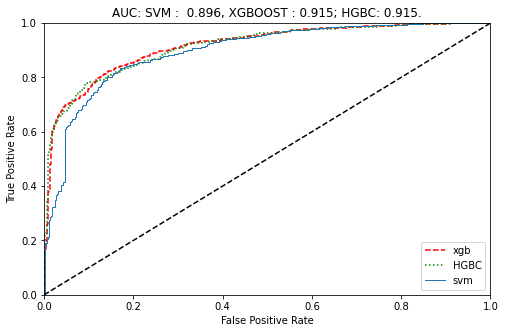

In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


auc_svm = roc_auc_score(Y_train, y_scores_1)
auc_xgb = roc_auc_score(Y_train, y_scores_2)
auc_hgbc = roc_auc_score(Y_train, y_scores_3)

plt.figure(figsize=(8,5))
plt.plot(fpr_xgb, tpr_xgb, "r--", label="xgb")
plt.plot(fpr_hgbc, tpr_hgbc, "g:", label="HGBC")
plt.plot(fpr_svm, tpr_svm, linewidth=1, label="svm")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC: SVM :  {0}, XGBOOST : {1}; HGBC: {1}.".format(round(auc_svm,3), round(auc_xgb,3), round(auc_hgbc,3)))
plt.legend(loc="lower right")
plt.show()

In [ ]:
print("SVM Metrics:\n")
print(classification_report(Y_test,predictions_1),'\n')
print("XGBoost metrics:\n")
print(classification_report(Y_test,predictions_2), '\n')
print("HGBC metrics:\n") 
print(classification_report(Y_test,predictions_3), '\n')

SVM Metrics:

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       149
           1       0.87      0.83      0.85       196

    accuracy                           0.83       345
   macro avg       0.83      0.83      0.83       345
weighted avg       0.83      0.83      0.83       345
 

XGBoost metrics:

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       149
           1       0.89      0.85      0.87       196

    accuracy                           0.86       345
   macro avg       0.85      0.86      0.86       345
weighted avg       0.86      0.86      0.86       345
 

HGBC metrics:

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       149
           1       0.91      0.81      0.86       196

    accuracy                           0.85       345
   macro avg       0.85      0.85      0.85       345
weighted avg       0.85

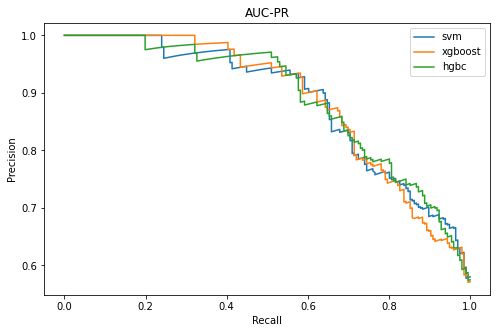

In [ ]:
from sklearn.metrics import precision_recall_curve
# plot the precision-recall curves
svm_precision, svm_recall, _ = precision_recall_curve(Y_test, yt_scores_1)
xgb_precision, xgb_recall, _ = precision_recall_curve(Y_test, yt_scores_2)
hgbc_precision, hgbc_recall, _ = precision_recall_curve(Y_test, yt_scores_3)

plt.figure(figsize=(8,5))
plt.plot(svm_recall, svm_precision, label='svm')
plt.plot(xgb_recall, xgb_precision, label='xgboost')
plt.plot(hgbc_recall, hgbc_precision,label='hgbc')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.title("AUC-PR")
plt.show()